In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch_nf.conditional_nf import NormFlow, ConditionedNormFlow
from torch_nf.exponential_families import MVN, Dirichlet
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Parameterizing the EFN arch.

In [2]:
D = 5
arch_type = 'coupling'
num_stages = 1
num_layers = 1
num_units = 15

hidden_layers = [100]

In [3]:
def dbg_check(tensor, name):
    num_elems = 1
    for dim in tensor.shape:
        num_elems *= dim
    num_infs = torch.sum(torch.isinf(tensor)).item()
    num_nans = torch.sum(torch.isnan(tensor)).item()
    
    print(name, "infs %d/%d" % (num_infs, num_elems), "nans %d/%d" % (num_nans, num_elems))
    return num_nans or num_infs

### Train the EFN

In [4]:
def EFNLoss(z, log_prob, eta, T):
    T_z = T(z)
    eta_dot_T = torch.matmul(T_z, eta[:,:,None])[:,:,0]
    dbg_check(T_z, 'T_z')
    dbg_check(eta_dot_T, 'eta_dot_T')
    return torch.mean(log_prob - eta_dot_T)

def train_efn(cnf, exp_fam, num_iters=1000):
    optimizer = torch.optim.Adam(cnf.parameters(), lr=1e-4)
    losses = []
    KLs = []
    for i in range(1, num_iters+1):
        print(i)
        eta = exp_fam.sample_eta(N=M)
        eta = torch.tensor(eta).float()
        z, log_prob = cnf(eta, N=N)
        
        f1 = dbg_check(eta, 'eta')
        f2 = dbg_check(z, 'z')
        f3 = dbg_check(log_prob, 'log_prob')
        if (f1 or f2 or f3):
            break

        loss = EFNLoss(z, log_prob, eta, exp_fam.T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        KL = np.mean(exp_fam.KL(z.detach().numpy(), log_prob.detach().numpy(), eta))

        if (i==1 or i % 100 == 0):
            _loss = loss.item()
            print('%d: loss=%.2E, KL=%.2E' % (i, _loss, KL))

        losses.append(loss.item())
        KLs.append(KL)
    return losses, KLs

In [5]:
M = 100
N = 100
num_iters = 2000


exp_fam = Dirichlet(D)

num_rs = 1
losses = []
KLs = []
cnfs = []

j = 4

np.random.seed(j)
torch.manual_seed(j)
nf = NormFlow(D-1, arch_type, True, num_stages, num_layers, num_units, support_layer=exp_fam.support_layer)
cnf = ConditionedNormFlow(nf, exp_fam.D_eta, hidden_layers)
_losses, _KLs = train_efn(cnf, exp_fam, num_iters=num_iters)
losses.append(_losses)
KLs.append(_KLs)
cnfs.append(cnf)


1
bij 0 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 1 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 2 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 3 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 4 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
ex infs 0/40000 nans 0/40000
sum_ex infs 0/10000 nans 0/10000
eta infs 0/600 nans 0/600
z infs 0/50000 nans 0/50000
log_prob infs 0/10000 nans 0/10000
T_z infs 0/60000 nans 0/60000
eta_dot_T infs 0/10000 nans 0/10000
1: loss=2.94E+01, KL=6.33E+00
2
bij 0 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 1 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 2 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 3 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
bij 4 input
z infs 0/40000 nans 0/40000
log_q_z infs 0/10000 nans 0/10000
ex infs 1

In [ ]:
fontsize = 14
plt.figure()
plt.plot(np.array(losses).T)
plt.xlabel("iterations", fontsize=fontsize)
plt.ylabel("loss", fontsize=fontsize)
plt.show()

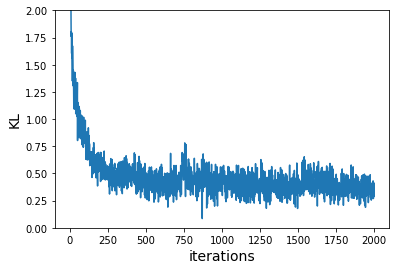

In [15]:
KLs = np.array(KLs)

plt.figure()
plt.plot(KLs.T)
plt.xlabel("iterations", fontsize=fontsize)
plt.ylabel("KL", fontsize=fontsize)
plt.ylim([0, 2])
plt.show()

In [20]:
mu = np.array([0., 0., 0., 0.])
Sigma = np.array([[1., 8., 0., .0],
                  [8., 1., 0., 0.],
                  [0., 0., 1., 0.],
                  [.0, 0., 0., 1.]])
mu = np.expand_dims(mu, 0)
Sigma = np.expand_dims(Sigma, 0)

eta = exp_fam.mu_to_eta(mu, Sigma)
z, log_prob = cnf(torch.tensor(eta).float(), N=N)

In [21]:
def plot_dist(z, log_prob):
    df = pd.DataFrame(z)
    z_labels = ["z%d" % d for d in range(1, D + 1)]
    df.columns = z_labels
    df["log_q_z"] = log_prob

    log_prob_std = log_prob - np.min(log_prob)
    log_prob_std = log_prob_std / np.max(log_prob_std)
    cmap = plt.get_cmap("viridis")
    g = sns.PairGrid(df, vars=z_labels)
    g = g.map_diag(sns.kdeplot)
    g = g.map_upper(plt.scatter, color=cmap(log_prob_std))

    g = g.map_lower(sns.kdeplot)
    return g

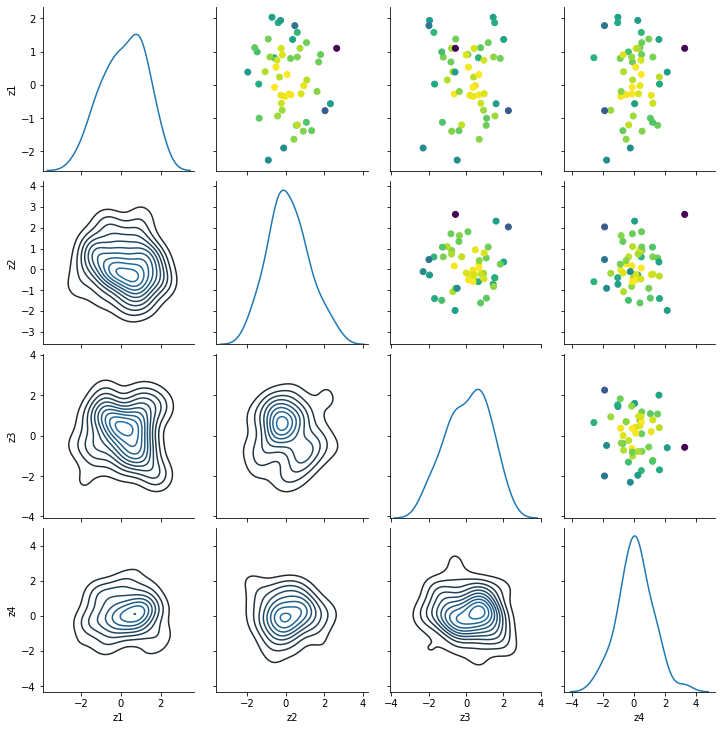

In [22]:
plot_dist(z[0].detach().numpy(), log_prob[0].detach().numpy())